## Imports

In [2]:
import sys
sys.path.append('../../')
import torch
import os
from datasets.nsd import NaturalScenesDataset
from datasets.nsd_clip import NSDCLIPFeaturesDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from utils.nsd_utils import plot_interactive_surface

### Global variables

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

subject = 1
partition = 'train'
data_root = '../../data/NSD'
roi = 'floc-faces'
hemisphere = 'right'

clip_extractor_type = "clip_2_0"

center_voxel = 137473
n_neighbor_voxels = 100

nsd = NaturalScenesDataset(
    root=data_root, 
    subject=subject, 
    partition=partition, 
    roi=roi, 
    # center_voxel=center_voxel,
    # n_neighbor_voxels=n_neighbor_voxels,
    hemisphere=hemisphere
)

dataset = NSDCLIPFeaturesDataset(nsd, clip_extractor_type, predict_average=True)
low_dim = dataset.compute_low_dim(0)
del nsd

## Visualize closest images

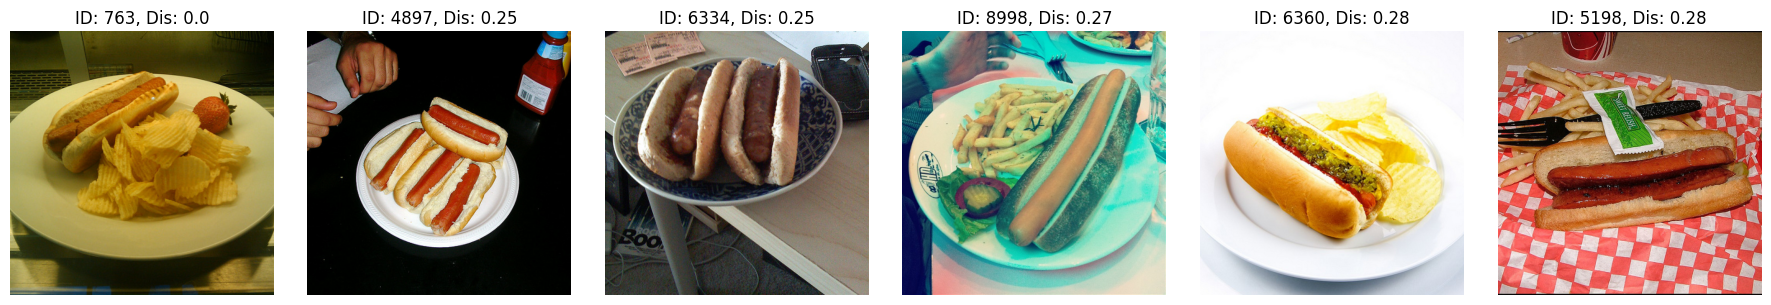

In [6]:
# Queried image index
idx = 763

# Obtain closest images
num = 5
closest = np.argsort(dataset.D[idx, :])[:num+1]

# Plot closest images
f, axes = plt.subplots(1, num+1, figsize=((num+1)*3, 3))
for i, c in enumerate(closest):
    img, _ = dataset[c]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f'ID: {c}, Dis: {str(np.round(dataset.D[idx, c],2))}')
plt.tight_layout()
plt.show()

## Visualize averaged responses

In [ ]:
# Queried image index
idx = 6450

# Obtain closest images
num = 50
closest = np.argsort(dataset.D[idx, :])[:num+1]
fmri_data_avg = dataset.nsd.fmri_data[closest].mean(axis=0)

plot_interactive_surface(
    fmri=fmri_data_avg,
    roi_indices=dataset.nsd.roi_indices,
    fs_indices=dataset.nsd.fs_indices,
    fs_coords=dataset.nsd.fs_coords,
    inverted_index_roi=pd.read_csv(os.path.join(data_root, f"subj{subject:02d}", f"inverted_index_roi_{hemisphere}.csv")),
    min_x=(40 if hemisphere == 'left' else -175),
    max_x=(175 if hemisphere == 'left' else -40),
    min_y=-200,
    max_y=200
)

## Visualize induced lower-dimensional manifold

### Targets averaged over _n_ neighbors

In [11]:
targets = np.round(dataset.targets, 2)
lim = 3
data = pd.DataFrame({'index': np.arange(len(low_dim)), 'x': low_dim[:, 0], 'y': low_dim[:, 1]})

fig = px.scatter(data, x='x', y='y', text=targets, hover_name='index')
fig.update_traces(marker=dict(size=5, opacity=0.5, color=targets, colorscale='RdBu_r'))
fig.update_layout(title='t-SNE with predictions', hovermode='closest', width=500, height=500)

fig.show()

Computing low dimensional representation...
Done.
